In [1]:
import pandas as pd
import sys
sys.path.append("../")
from tcad.tools.nntools import SmilesDataSet, SmilesEncoder
from tcad.deep.fit import train_gan
from torch.utils.data import DataLoader
from tcad.deep.models import GAN
import matplotlib.pyplot as plt
import torch
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL) 


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#helper functions
def to_strong_ones(matrix, threshold):
    zero_matrix = np.zeros_like(matrix)

    for idx, row in enumerate(matrix):
        max_val, max_idx = np.max(row), np.argmax(row)
        
        if max_val >= threshold:
            zero_matrix[idx, max_idx] = 1
    
    return zero_matrix


def check_smile(smile):
    mol = Chem.MolFromSmiles(smile)
    
    if mol == None:
        return "Not Valid"
    
    return "Valid"

In [3]:
data = pd.read_csv("../data/androgen_data.csv")
smiles = data["canonical_smiles"].to_list()

smiles_dataset = SmilesDataSet(smiles, gan=True)
senc = SmilesEncoder(smiles, gan=True)
dataloader = DataLoader(smiles_dataset, batch_size=128)

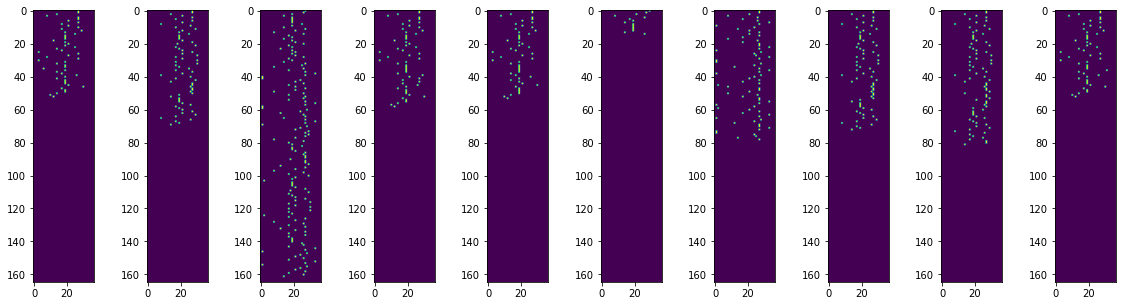

In [4]:
_, ax = plt.subplots(1, 10, figsize = (20, 5))

for i in range(10):
    ax[i].imshow(smiles_dataset[i].squeeze())

In [6]:
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

model = GAN(240).to(DEVICE)
model.load_state_dict(torch.load("GAN_model"))

optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [47]:
train_gan(dataloader, model, optim_gen, optim_discr, loss_func="wasserstein", epochs=150)

Epoch: 0 Discriminator loss: -0.22955948158571152 Generator loss: -0.395951079167682
Epoch: 10 Discriminator loss: -0.21904979251478982 Generator loss: -0.2648354099959047
Epoch: 20 Discriminator loss: -0.20825338559399192 Generator loss: -0.4308119891022745
Epoch: 30 Discriminator loss: -0.20157016630384306 Generator loss: -0.31436158291621896
Epoch: 40 Discriminator loss: -0.17636306252011863 Generator loss: -0.34821078442806336
Epoch: 50 Discriminator loss: -0.18289763783350824 Generator loss: -0.11541556645269004
Epoch: 60 Discriminator loss: -0.17097000121552794 Generator loss: -0.08152026458258302
Epoch: 70 Discriminator loss: -0.17841195945601432 Generator loss: -0.2229824234624352
Epoch: 80 Discriminator loss: -0.21178372385110356 Generator loss: -0.3958761420397631
Epoch: 90 Discriminator loss: -0.1806948023669663 Generator loss: -0.4038763147715622
Epoch: 100 Discriminator loss: -0.19231871752876098 Generator loss: -0.4620564432886146
Epoch: 110 Discriminator loss: -0.2038957

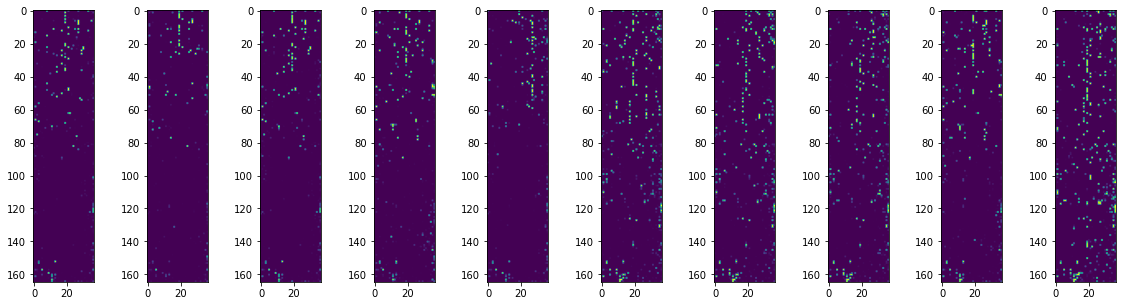

In [51]:
noise = torch.randn(240, model.latent_dim, device=DEVICE)

out = model.generator_forward(noise).detach().cpu().numpy().squeeze()

_, ax = plt.subplots(1, 10, figsize = (20, 5))

for i in range(10):
    ax[i].imshow(out[i])

In [49]:
generated_smiles = []
valid_smiles = []
n_iters = 100
min_smile_len = 10
threshold = 0.3

with torch.no_grad():
    
    for i in tqdm(range(n_iters)):

        noise = torch.randn(240, model.latent_dim, device=DEVICE)
        out = model.generator_forward(noise).detach().cpu().numpy().squeeze()
        
        for j in out:
            
            strong_one = to_strong_ones(j, threshold)
            try:
                smile = senc._decode_smile(strong_one)
                generated_smiles.append(smile)
            
            except KeyError:
                continue
            
            if check_smile(smile) == 'Valid' and len(smile)>min_smile_len and smile not in smiles:
                valid_smiles.append(smile)

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


In [50]:
sorted(generated_smiles, key=lambda x: len(x), reverse=True)[:5]

['=lccc(CC2[c2[cc(SOc(ccccc1',
 '=lccc(CCC[c2[@c(SOc(ccccc1',
 '=lccc(CCC[c2[@c(SOc(ccccc1',
 '=lccc(CCC[c2[@c(SOc(ccccc1',
 '=lccc(cCC[c2[@c(SOc(c#ccc1']